## 1.

*Recogiendo los datos de coronavirus de la página https://ourworldindata.org/coronavirus-source-data* 

A partir de la letra de tu DNI, elige al país que empieza por dicha letra que más fallecidos tenga. Si el país elegido no está entre el top 20 de fallecidos, elige como país España.

En este caso, utilizaremos las columnas:

- Nuevos casos
- Nuevos fallecidos
- Población
- Fallecidos totales
- Casos totales

La fecha debe estar en el índice.

1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

2. Elimina la columna "Población".

3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

4. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y batches = 7 para este ejercicio y solo para la columna "nuevos casos".

In [65]:
## Import the necessary libraries

import pandas as pd 
import numpy as np 

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


import matplotlib.pyplot as plt 
import seaborn as sns

In [47]:
df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', sep=',')

from data_mining_tb import df_info
df_info(df=df)

####
DATAFRAME INFO
####

Number of rows: 68602
Number of columns: 59

#### DATAFRAME COLUMNS ####
 Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fu

In [48]:
df.set_index('date', inplace=True)

## After that, create a function that selects a country from the dataset which begins with the first letter of your ID card

In [49]:
def id_letter_country():
    '''
    @leosanchezsoler
    This function returns data from a country with the first letter of your ID-card
        Parameters:
            - id_letter: a string with the letter of your ID-card
    '''
    id_letter = str(input('Please, enter your ID card letter'))
    if len(id_letter) > 1 or type(id_letter) != str:
        print('Sorry mate, but your ID only has one letter. Please, check what you have done and try again')
    
    #########################################################
    else:
        # Create the necessary variables

        countries = df.location.unique()
        countries_death_rank = df.groupby('location').sum()['total_deaths'].sort_values(ascending=False).head(20).index
        your_countries = []
        for pos, country in enumerate(countries):
            if country[pos].startswith(id_letter):
                your_countries.append(country)
                print(f'{country} is for you!')
            else: 
                print('Spain is your country')
                break
        

id_letter_country()

Spain is your country


## My country is Spain, so I will use their data


In [67]:
Spain_df = df[df.location == 'Spain']
df_info(df=Spain_df)

####
DATAFRAME INFO
####

Number of rows: 378
Number of columns: 58

#### DATAFRAME COLUMNS ####
 Index(['iso_code', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccin

# In this case, we will use the following columns:

- new_cases
- new_deaths
- population
- total_deaths
- total_cases

In [68]:
Spain_df = Spain_df[['new_cases', 'new_deaths', 'population', 'total_deaths', 'total_cases']]
Spain_df.describe()

,new_cases,new_deaths,population,total_deaths,total_cases
count,378.000000,347.000000,378.0,347.000000,3.780000e+02
mean,8084.748677,186.590778,46754783.0,32086.279539,7.754289e+05
std,13332.841576,277.108135,0.0,14418.717250,8.249078e+05
min,-10034.000000,-1918.000000,46754783.0,1.000000,1.000000e+00
25%,0.000000,0.000000,46754783.0,27136.000000,2.195780e+05
50%,1591.500000,78.000000,46754783.0,28838.000000,3.143620e+05
75%,10736.500000,314.000000,46754783.0,41863.500000,1.381218e+06
max,93822.000000,1623.000000,46754783.0,64747.000000,3.056035e+06


In [69]:
Spain_df.drop(columns=['population'], inplace=True)
Spain_df

,new_cases,new_deaths,total_deaths,total_cases
date,,,,
2020-02-01,1.0,NaN,NaN,1.0
2020-02-02,0.0,NaN,NaN,1.0
2020-02-03,0.0,NaN,NaN,1.0
2020-02-04,0.0,NaN,NaN,1.0
2020-02-05,0.0,NaN,NaN,1.0
...,...,...,...,...
2021-02-08,47095.0,909.0,62295.0,2989085.0
2021-02-09,16402.0,766.0,63061.0,3005487.0
2021-02-10,18114.0,643.0,63704.0,3023601.0


In [71]:
Spain_df.fillna(Spain_df.mean(), inplace=True)

## Slice the dataset and start the data in the 14-03-2020, when the alarm state was declared

3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

In [81]:
# X --> Features
X = np.array(Spain_df[['new_deaths', 'total_deaths', 'total_cases']])

# y --> target
y = np.array(Spain_df[['new_cases']])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=55)

# Assign the model to a variable
polynomial_f = PolynomialFeatures()
X_poly = polynomial_f.fit_transform(X_train, y_train)
lin_reg = LinearRegression()

# Define parameters for cross validation
rkf = RepeatedKFold(n_splits=7, n_repeats=23)
n_scores = cross_val_score(lin_reg, X_train, y_train, scoring='r2', cv=rkf, n_jobs=-1, error_score='raise', verbose=1)

neg_mean_abs_error = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=rkf, n_jobs=-1, error_score='raise', verbose=1)
# Create a list to store errors
r2_score_list = []


for i, (train, val) in enumerate(rkf.split(X=X_train)):
    print("\nITERATION", i+1, ":")
    print(train)
    print('\nBatch size:', len(train))
    print("-------------------")
    print('r2_score:', n_scores[i])
    print('Neg mean absolute error:', neg_mean_abs_error[i])
    r2_score_list.append(n_scores)    
    if i == 1:
        print('##################')

# Train the model after cross validation

lin_reg.fit(X_poly, y_train)

y_pred = lin_reg.predict(X_poly)
print('y_pred:', y_pred)
#######################################

rmse = mean_squared_error(y_train, y_pred, squared=True)
print('RMSE:', rmse)


print('\ny_pred', y_pred.shape)

0.47425794199448024
Neg mean absolute error: -4893.361099074097

ITERATION 150 :
[  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  23  25  26  28  29  30  32  33  34  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  58  60
  61  62  64  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  84  85  86  87  88  89  93  94  95  96  97  98  99 102 103 104 105
 106 107 108 109 110 111 112 113 115 117 118 119 120 121 122 123 125 127
 128 129 131 132 133 134 135 137 138 139 140 141 143 144 145 147 148 149
 150 151 152 153 154 156 157 158 159 160 161 162 164 165 166 167 168 169
 170 171 173 174 177 178 180 181 182 183 184 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 226 227 228 230 231
 232 233 234 235 236 237 238 240 241 242 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 26

In [75]:
X_train.shape

(302, 3)

In [76]:
y_train.shape

(302, 1)

In [ ]:
kf = KFold(n_splits=3)

error = []

    model.fit(Xtrain, ytrain)

    pred = model.predict(X_val)

    current_error = mean_squared_error(y_val, pred) # error per iteration

    error.append(current_error)

 print(np.mean(error)) # get mean error after CV

## I still have to visualize the proper columns
- Ask a teacher for it

Automatically created module for IPython interactive environment
Average difference of 0.007581 with std. dev. of 0.007833.


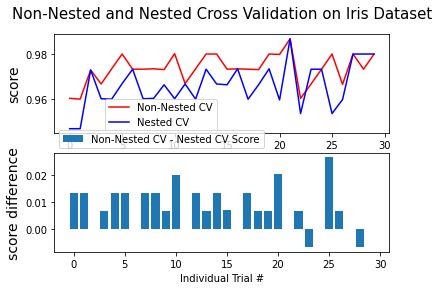

In [10]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np

print(__doc__)

# Number of random trials
NUM_TRIALS = 30

# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100],
          "gamma": [.01, .1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation on Iris Dataset",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

plt.show()